# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The Smartcab is completely idle (doesn't move) during the first run of the simulation. It gets rewarded/penalised based on its current state, if there are any traffic violations and the traffic on the streets.

Because the Smartcab is not moving, we are only able to notice three states:
1. Properly idled at a red light. ***(1^)***
2. Agent idled at a green light with oncoming traffic. ***(2^)*** 
3. Agent idled at a green light with **NO** oncoming traffic. ***(3^)***

The algorithm grants rewards to the Smartcab depending on their current state and if that state has changed. For example, if the Smartcab was on a green light and stops when a red light is shown ***(1^)***, a high reward will be given (2.27). As the traffic light will stay red for a few seconds, the following rewards for staying idle at the red light will start low but will keep incrementing (1.36,  1.55, 2.31, 2.83) until the next traffic light change. This incrementing behaviour is consistent when the Smartcab is in the same state for some time, be it positive ***(1^)*** or negative ***(3^)*** rewards. For example, the smart cab is in state ***(3^)*** for 4 seconds, the first reward will be -4.05, followed by -4.14, -4.50, -4.63. 

The rewarding system takes safety seriously as it grants positive rewards when the Smartcab commits no traffic violations and is careful with oncoming traffic ***(2^)***. It penalises (negative rewards) heavily if the Smartcab is idle when there is a green light and no oncoming traffic ***(3^)***.

The traffic light changes the rewards given to the Smartcab depending if the action taken is the right action for the state or not.



### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

* The three flags can be set in agent.py:
    * learning: If set to True, it will force the driving agent to use Q-learning
    * alpha: We specify how fast will the agent learn. By default is set to 0.5
    * enforce_deadline: It captures when the agent reaches the destination in time. By default is set to False
* The function in environment.py is act(self, agent, action)
* The render() function updates and displays the current state and reward of the agent in the Graphical interface. render_text() displays the state and rewards of the agent in terminal - only text. 
* The planner -> next_waypoint() function first considers the East-West direction.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


#### *%%bash*

*python2 smartcab/agent.py --enforce_deadline=True --log_metrics=True --update_delay=0.01 --n_test=10 --params_output=sim_no-learning_params.txt*

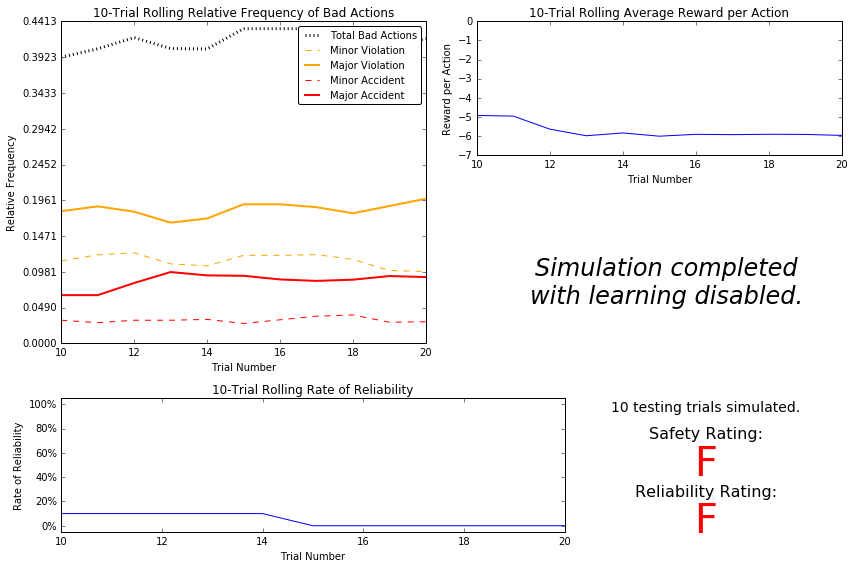

In [70]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

The charts above display what is expected from someone that drives randomly - extremely unsafe and unreliable.

* As shown in the upper left chart, the agent is making bad decision 40% of the time. Those bad decisions cause an accident around 33% of the time -> (Minor accident + Major accident) / Total Bad Actions.
* The lower left chart show us the reliability of the agent. It is surprising the at the beginning it was reliable 10% of the time. When the simulation was running, it completed successfully a couple of time, which is why it was considered 10% reliable at some time. In the end, it drops to 0%.
* Apart from the rewards described already in Question 1, new rewards were discovered here. The agent is heavily penalised when performing bad actions, e.g. driving left through a red light (10.65), driving left through a red light with traffic and cause a major accident (-39.57), driving forward through a red light. (-9.05), driving left through traffic and cause a minor accident (-20.65). Also, positive rewards are given when following the waypoint correctly, e.g. followed the waypoint left (2.52), and even when not following it but not causing any faults or accidents, e.g. drove forward instead of right (0.49)
* The upper right chart shows us the Rolling average reward per action. Here, we can see that the rolling average reward is always between -4 and -6, meaning that the algorithm is consistently performing poorly and there isn't much change as the number of trials increases.
* The Smartcab will be considered unreliable as the passengers will rarely be on time. Also, it is considered unsafe as it performs too many bad actions, traffic violations and the probability of being in an accident are too high.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

#### *Relevant Features*

Features most relevant for safety: Inputs - light, left, oncoming. These features are needed to train the Smartcab drive safely. 
* Light will indicate to the Smartcab if its ok to move (at least forward) or stay idle.
* After lights, it will need to take in consideration left, oncoming to identify if its safe to perform the action (forward, turn left or right). 

Features most relevant for efficiency: waypoint. The waypoint will indicate our Smartcab the best way to get to our destination. 

#### *Irrelevant Features*

inputs.right is not relevant as all cars drive on the right side and there are no one way streets with multiple lanes, meaning.... there will never be a car on the right side of our agent as it is not possible to change lanes. Also, at intersections we only need to take in consideration input.lights and input.left, e.g if we are at an intersection and the light is red, we will be idle or are only able to turn right by checking inputs.left. If we are an intersection and the light is green, we will have the Right-of-Way (if we want to turn right) and only take in consideration inputs.left if we want to turn left.

Deadline is not appropiate for safety or efficiency. It is preferable that our agent takes longer and be safe instead of taking "shortcuts" and not obeying traffic conditions / be involved in accidents. The deadline will provide feedback to our Smartcab regarding how long it took to make it to a destination and it will help to know the reliability of the service but it will not make it safer or more efficient.  

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

| Features        | PossibleValues       | Length |
| :---------------|:---------------------|:--------:|
| input.light     | green, red           | 2 |
| input.left      | None, forward, left, right | 4 |
| input.oncoming  | None, forward, left, right | 4 |
| waypoint        | forward, left, right | 3 |

**Size of the State space** -> 2 x 4 x 4 x 3 = 96

The driving agent will need to learn 96 policies to cover every possible state. Currently, our training trials are composed of 20 steps, and the agent is only doing 20 training trials. This might not be enough to train all 96 policies properly. We should test increasing our training trials in order to be able to train all policies multiple times.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

#### *%%bash*

*python2 smartcab/agent.py --learning=True --decay_fx=initial --enforce_deadline=True --log_metrics=True --update_delay=0.01 --n_test=10 --params_output=sim_default-learning_params.txt*

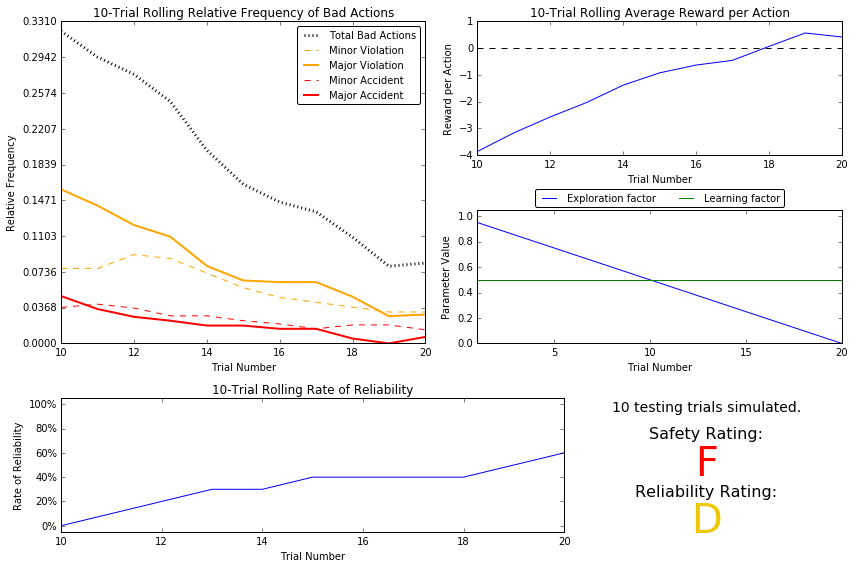

In [131]:
# Load the 'sim_default-learning' file from the default Q-Learning simulationls
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

* When compared with Question 3, we can see that all the values for the Q-Learning agent are better. Values for Total bad actions, reward per action avg, violations, and accidents are lower for our Q-Learning agent (which makes it a bit safer) and we can see that the Q-Learning agent is learning. Also, the Q-learning agent has a reliability of close to 60% which is better than the 0-10% achieve by the basic driving agent.
* 20 training trials were required. It does make sense as we start with an epsilon of 1.0 and we are decreasing it by 0.05 -> 20 * 0.05 = 1
* Yes, as we can see in the Exploration Factor / Learning Factor chart, the Exploration consistently decreases with the number of trials
* The number of bad actions decrease with more training. It started close to 0.33 and finished with a value close to 0.08. Also we can see that the Average reward per action improved with more training, from ~ -4 to ~ 0.5.
* Safety is still the same - Rating F. Reliability has improved but still not great - Rating D. Even though the agent is learning and performing better, the ratings are still not good enough for the real world needs. *Note: * The rating changes with every run, meaning that the results are not consistent. 

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=oneovertp2 --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.5 --epsilon=1.0 --tolerance=0.05 --params_output=sim_improved-learning_params-1.txt*

In [132]:
!cat sim_improved-learning_params-1.txt

learning = True <type 'bool'>
alpha = 0.5 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.05 <type 'float'>
decay_fx = oneovertp2 <type 'str'>
params_output = sim_improved-learning_params-1.txt <type 'str'>


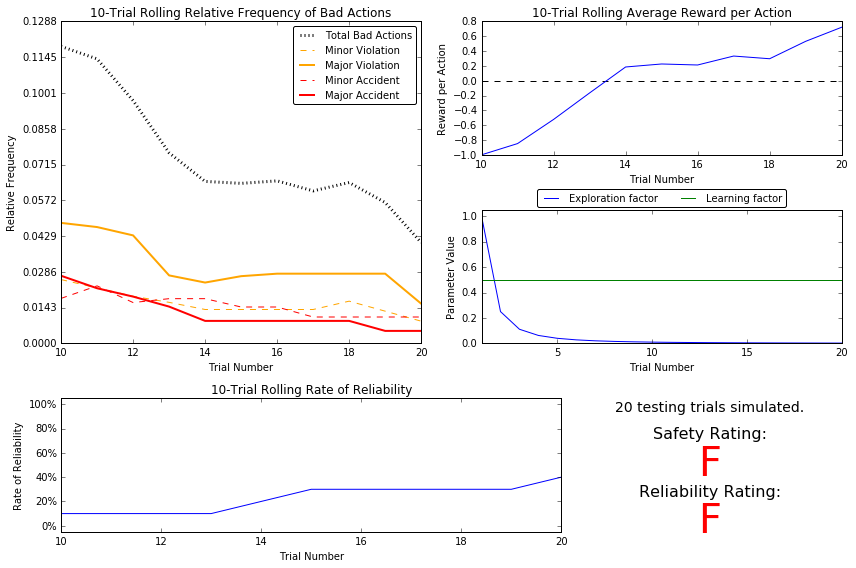

In [133]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=oneovertp2 --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.1 --epsilon=1.0 --tolerance=0.01 --params_output=sim_improved-learning_params-2.txt*

In [134]:
!cat sim_improved-learning_params-2.txt

learning = True <type 'bool'>
alpha = 0.1 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.01 <type 'float'>
decay_fx = oneovertp2 <type 'str'>
params_output = sim_improved-learning_params-2.txt <type 'str'>


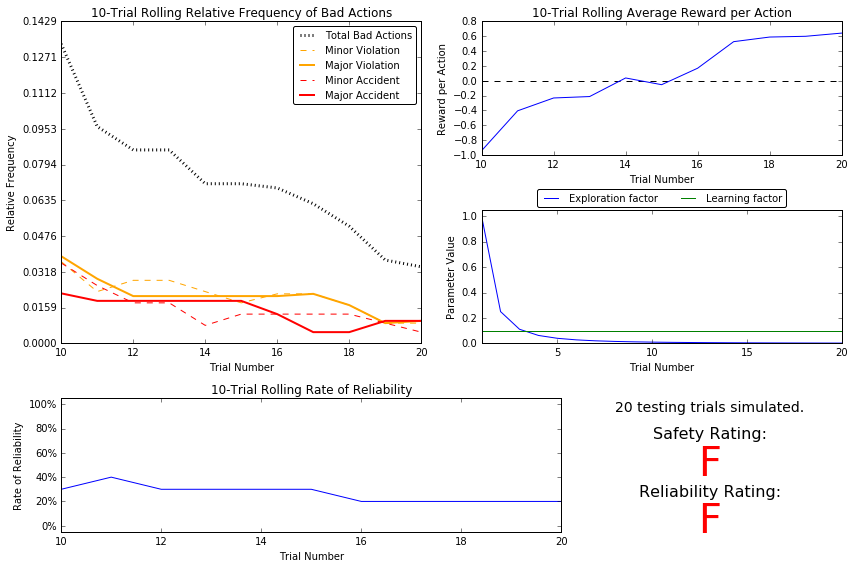

In [135]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=oneovertp2 --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.01 --epsilon=1.0 --tolerance=0.001 --params_output=sim_improved-learning_params-3.txt --display=True*

In [136]:
!cat sim_improved-learning_params-3.txt

learning = True <type 'bool'>
alpha = 0.01 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.001 <type 'float'>
decay_fx = oneovertp2 <type 'str'>
params_output = sim_improved-learning_params-3.txt <type 'str'>


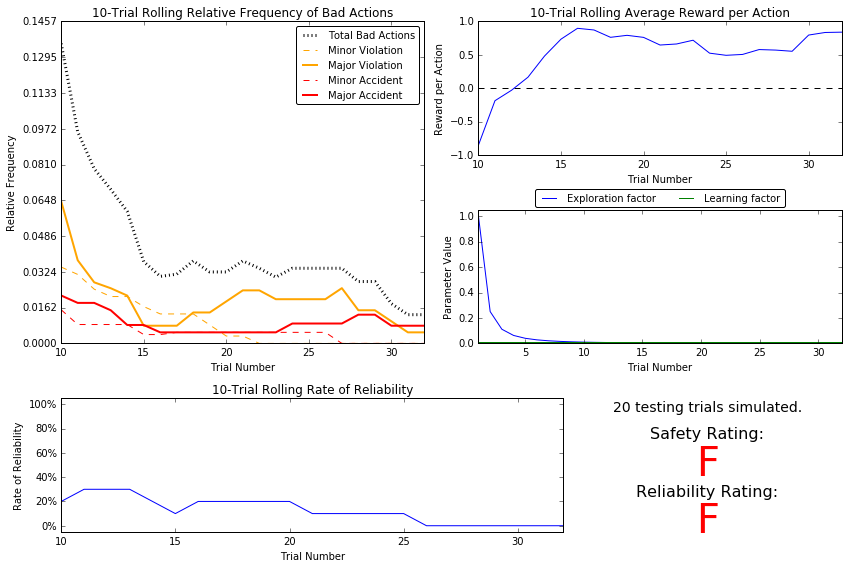

In [137]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=expat --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.01 --epsilon=1.0 --tolerance=0.05 --params_output=sim_improved-learning_params-4.txt --display=True*

In [138]:
!cat sim_improved-learning_params-4.txt

learning = True <type 'bool'>
alpha = 0.01 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.05 <type 'float'>
decay_fx = expat <type 'str'>
params_output = sim_improved-learning_params-4.txt <type 'str'>


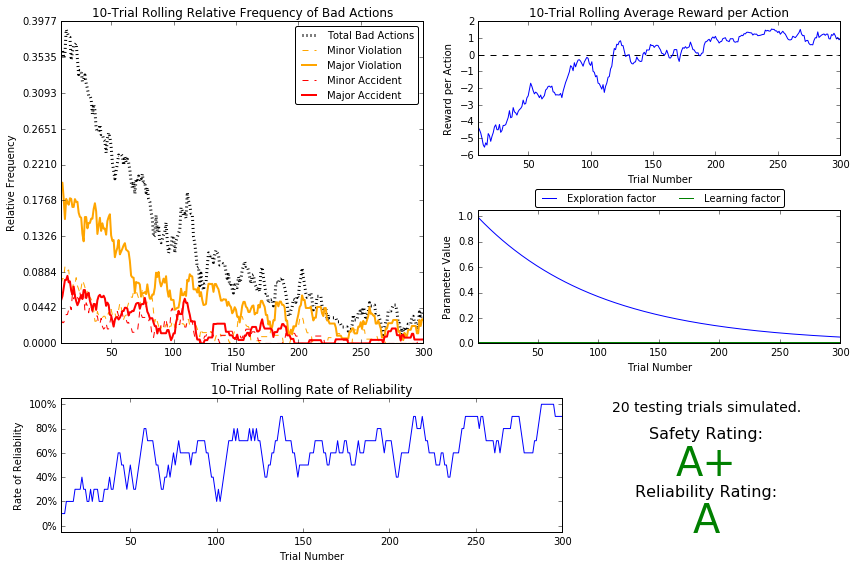

In [139]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=expat --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.005 --epsilon=1.0 --tolerance=0.001 --params_output=sim_improved-learning_params-9.txt --display=True*

In [140]:
!cat sim_improved-learning_params-9.txt

learning = True <type 'bool'>
alpha = 0.005 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.001 <type 'float'>
decay_fx = expat <type 'str'>
params_output = sim_improved-learning_params-9.txt <type 'str'>


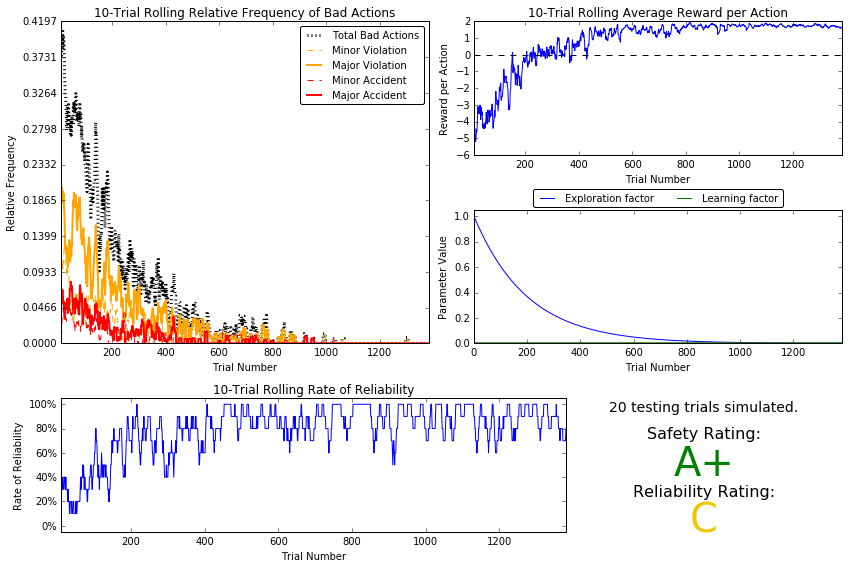

In [141]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

## Best performing simulation

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=abscosat --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=50 --alpha=0.01 --epsilon=1.0 --tolerance=0.005 --params_output=sim_improved-learning_params-8.txt --display=True*

In [144]:
!cat sim_improved-learning_params-8.txt

learning = True <type 'bool'>
alpha = 0.01 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 50 <type 'int'>
tolerance = 0.005 <type 'float'>
decay_fx = abscosat <type 'str'>
params_output = sim_improved-learning_params-8.txt <type 'str'>


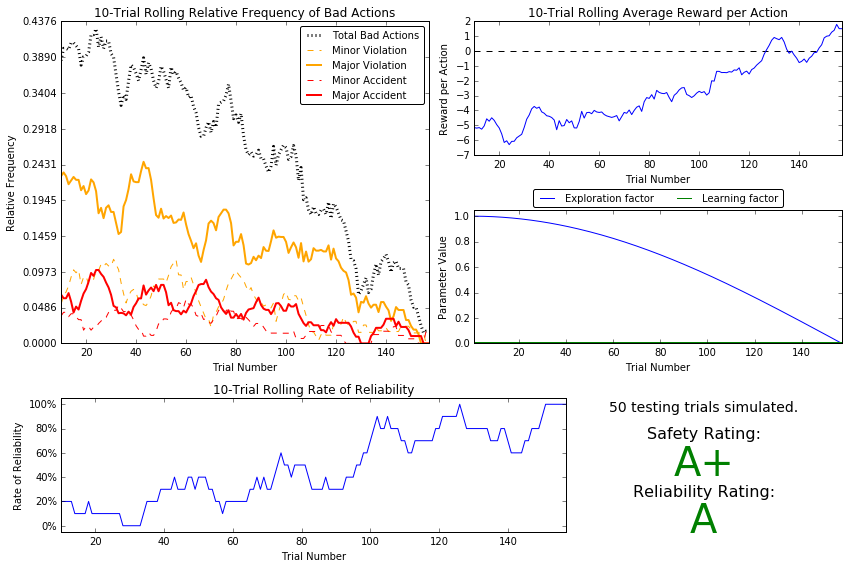

In [145]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

#### *%%bash*

*python2 smartcab/agent.py --learning=True --optimized=True --decay_fx=abscosat --enforce_deadline=True --update_delay=0.01 --log_metrics=True --n_test=20 --alpha=0.01 --epsilon=1.0 --tolerance=0.001 --params_output=sim_improved-learning_params-7.txt --display=True*

In [142]:
!cat sim_improved-learning_params-7.txt

learning = True <type 'bool'>
alpha = 0.01 <type 'float'>
epsilon = 1.0 <type 'float'>
enforce_deadline = True <type 'bool'>
update_delay = 0.01 <type 'float'>
display = True <type 'bool'>
log_metrics = True <type 'bool'>
optimized = True <type 'bool'>
n_test = 20 <type 'int'>
tolerance = 0.001 <type 'float'>
decay_fx = abscosat <type 'str'>
params_output = sim_improved-learning_params-7.txt <type 'str'>


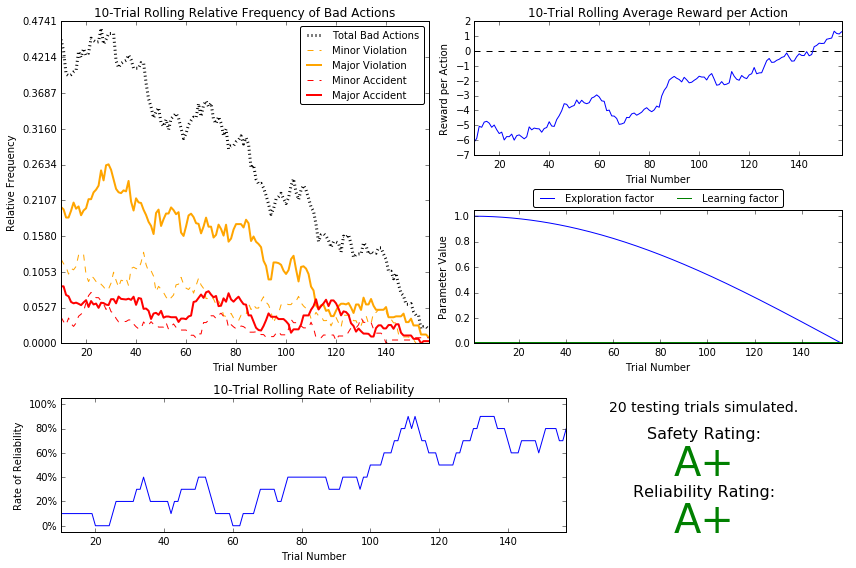

In [143]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

I tested the Smartcab with different parameters and decay functions. The questions will be answered taking in consideration the best performing simulation - sim_improved-learning_params-9. The table below captures the different parameters used and the Smartcab Safety and Reliability ratings:

| Id | learning | alpha | epsilon | optimized | n_test | tolerance | decay_fx | Safety Rating | Reliability Rating |
| :---------: || :--------- | :--------- | :--------- | :--------- | :--------- | :--------- | :--------- | :---------: | :---------: |
| 0 | False | 0.5 | 1.0 | False | 10 | 0.05 | initial | F | F |
| 1 | True | 0.5 | 1.0 | True | 10 | 0.05 | initial | F | D |
| 2 | True | 0.5 | 1.0 | True | 20 | 0.05 | oneovertp2 | F | F |
| 3 | True | 0.1 | 1.0 | True | 20 | 0.01 | oneovertp2 | F | F |
| 4 | True | 0.01 | 1.0 | True | 20 | 0.001 | oneovertp2 | F | F |
| 5 | True | 0.01 | 1.0 | True | 20 | 0.05 | expat | A+ | A |
| 6 | True | 0.005 | 1.0 | True | 20 | 0.001 | expat | A+ | C |
| 7 | True | 0.01 | 1.0 | True | 20 | 0.005 | abscosat | A+ | A |
| **8** | **True** | **0.01** | **1.0** | **True** | **20** | **0.001** | **abscosat** | **A+** | **A+** |

* The function with the most consistent results was $$ \epsilon = \cos(at), \textrm{for } 0 < a < 1$$

* Close to 160 Training trials were needed to get a good performance from the Smartcab test
* Epsilon = 1.0, Tolerance = 0.005, and Alpha = 0.01 (Id - 7). These values were used as I noticed that the simulation values were decreasion with the decaying function selected. I also tested with Tolerance=0.001 and Alpha=0.01 (Id - 8) to test it with a lower tolerance and see the behaviour of the Smartcab over time. This was the best results achieved for the simulation, having an overall rating of A+. Notice that the e power to -alpha * t function was also tested and very good results were achieved (Id - 5, 6)
* The default Q-learner had a Safety and Reliability rating of F and D. Our optimised Smartcab performs better (making less bad actions, violations, and accidents) than the default Q-Learner achieving a Safety and Reliability rating of A+. In our optimised Smartcab the bad actions, violations, and accidents are close to 0, whilst the default Q-Learner were high enough (0.15, 0.06, 0.03 - respectively) to make our Smartcab inefficient.
* Yes, if it hadn't learnt policies appropiately it's ratings would not be as good (A+). Our basic algorithm and default Q-learner had ratings of F and D.
* Yes, the Smartcab has an A+ rating for Safety and Reliability which are the maximum values that can be achieved.


### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

The states described below have the following structure: (light, oncoming, left, waypoint)

Not every state recorded has an optimal policy. In the examples below we will show states that have optimal, not-so-optimal and wrong policies:

## **Optimal**

| Light | Oncoming | Left | Waypoint |
| ----- | -------- | ---- | -------- |
| green | right  | None | forward    |

Next action:
* forward : 0.17
* right : 0.00
* None : -0.24
* left : -0.21

As seen in the state above, the agent will perform the optimal action (forward) and does not have any conflicts with other actions as None and left are heavily penalised.


| Light | Oncoming | Left | Waypoint |
| ----- | -------- | ---- | -------- |
| red | None  | left | forward    |

Next action:
* forward : -0.48
* right : 0.06
* None : 0.36
* left : -1.00

In the case above we have a red light, the agent should not go forward or turn left. It can stay or go right. Given the traffic conditions and the waypoint we can see that the weights assigned indicate that the car should stay.

## **Not-so-optimal**
 
| Light | Oncoming | Left | Waypoint |
| ----- | -------- | ---- | -------- |
| green | left  |right | left    |

Next action:
* forward : 0.01
* right : 0.08
* None : 0.00
* left : 0.04

Here the agent will prefer to turn right instead of waiting and going left. This can impact the reliability of the agent as it could end up extending the route significantly. It depends on where the target destination is located.


## **Wrong**

| Light | Oncoming | Left | Waypoint |
| ----- | -------- | ---- | -------- |
| green | left  | left | forward    |

Next action:
* forward : 0.05
* right : 0.10
* None : 0.02
* left : 0.03

The max action here is turn right when we need to go forward. The agent should go forward as we have the right-of-way in this case.

In this case the forward action should have a higher weight associated to it, 0.5.


-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.